<a href="https://colab.research.google.com/github/sodiumnitrate/RNN-toy-problem/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary addition with Recurrent Neural Networks (RNNs)

RNNs are great for processing sequential data. They are very similar to feedforward neural networks, but there is information flow between consecutive nodes of the hidden layer. They look like this (image reproduced from the book [*Deep Learning*](https://www.deeplearningbook.org/), by Goodfellow, Bengio, and Courville):



Frame 1.svg

Inspired by [this blog post](https://medium.com/vincents-blog/recurrent-neural-network-from-scratch-binary-addition-task-e2c7fb5ca37b), I will be going through how RNNs work by applying it to adding two binary numbers. Of course, we don't actually need a neural network for this task, [as computers are pretty good at it already](https://en.wikipedia.org/wiki/Adder_(electronics). (Not to mention -- so are we!)

Let's first take a look at what the variables in the image above are:

For binary addition, $x^{(t)}$ is a two-dimensional vector (a pair of bits). This is the input dimension.

Using a sigmoid activation $\sigma (x)=1/(1+\exp{(-x)})$, we write

$$
\mathbf{h}^{(t)}=\sigma(W \mathbf{h}^{(t-1)}+U\mathbf{x}^{(t)}),
$$
where $W$ and $U$ are weight matrices. The output is

$$
\mathbf{\hat{y}}^{(t)}=\sigma(V \mathbf{h}^{(t)}).
$$

$L^{(t)}$ is the loss, given by

$$
L^{(t)} = \frac{1}{2}(\hat{\mathbf{y}}^{(t)}-\mathbf{y}^{(t)})^2,
$$
where $\mathbf{y}^{(t)}$ is the ground truth.


## Example binary addition

Suppose we want to add `010=2` and `011=3`. The result is `101=5`. The RNN would look like this:
Frame 3(1).svg

We feed the pair of smallest bits first: `(0,1)`. Adding these two bits results in `1`, and the information that there is no bit to be carried over to the next bit is communicated via the first lateral connection from $\mathbf{h}^{(0)}$ to $\mathbf{h}^{(1)}$.

Suppose we have a hidden dimension of `5`. The dimensions of the matrices involved can be illustrated as follows:
Frame 4.svg

In our example, the binary dimension $d_f$ is `3`. This means that the largest number we can deal with is `111=7`. We can generate a dataset that maps the sum of all `3`-dimensional binary numbers to other `3`-dimensional binary numbers. Note that this restricts the input numbers, as a pair of `3`-d binary numbers can add up to `4`-d binary numbers. Consider, for instance `111` + `001` = `1000`. Our dataset will thus contain:

input 1 | input 2 | output
-- | -- | --
001 | 001 | 010
001 | 010 | 011
001 | 100 | 101
001 | 011 | 100
010 | 011 | 101

Reversing the bits, our input tensor will look like this:
```python
X = [
     [[1,0,0],[1,0,0]],
     [[1,0,0],[0,1,0]],
     [[1,0,0],[0,0,1]],
     [[1,0,0],[1,1,0]],
     [[0,1,0],[1,1,0]],
    ]
```
with outputs
```python
y = [
      [0,1,0],
      [1,1,0],
      [1,0,1],
      [0,0,1],
      [1,0,1]
    ]
```

## PyTorch implementation

Let's start with generating the data. We first define a function that converts `int`s to the list of bits we require:

In [100]:
from typing import List

def int2bin(num: int, dimension: int) -> List[int]:
  res = [int(el) for el in bin(num)[2:]]

  if len(res) == dimension:
    return res

  if len(res) > dimension:
    raise ValueError(f"The provided number {num} exceeds the requested dimension {dimension}.")

  pad = [0] * (dimension - len(res))
  res = pad + res

  return res

Let's see this function in action:

In [101]:
print(int2bin(5, 3))
print(int2bin(16, 8))

try:
  print(int2bin(15, 3))
except:
  print("We requested a number that is 4-dimensional to be represented in 3-d!")

[1, 0, 1]
[0, 0, 0, 1, 0, 0, 0, 0]
We requested a number that is 4-dimensional to be represented in 3-d!


Next, we generate the "data" -- first as regular lists. And then we convert to PyTorch tensors.

In [102]:
import torch

# choose a binary dimension
BIN_DIM = 5
largest_number = 2 ** BIN_DIM - 1

# list of inputs
X = []

# list of outputs
y = []

for x1 in range(largest_number // 2 + 1):
  for x2 in range(x1, largest_number // 2 + 1):
    Xi = [int2bin(x1, BIN_DIM)[::-1],
          int2bin(x2, BIN_DIM)[::-1]]
    X.append(Xi)

    yi = int2bin(x1+x2, BIN_DIM)[::-1]
    y.append(yi)

# convert to torch tensor
X = torch.Tensor(X)
y = torch.Tensor(y)

# print shapes of the tensors we just created
print(X.shape, y.shape)
print(len(X), len(y))
print(X[0].shape, y[0].shape)

torch.Size([136, 2, 5]) torch.Size([136, 5])
136 136
torch.Size([2, 5]) torch.Size([5])


Next, we create a custom dataset class and use it to create train and test datasets.

Custom dataset classes inherit from `torch.utils.data.Dataset`, and have to have `__len__` and `__getitem__` defined. These methods allow for other PyTorch methods to figure out how many elements the dataset has and how to extract examples from the dataset.

In [103]:
from torch.utils.data import Dataset

class CustomBinaryDataset(Dataset):
  def __init__(self, dimension: int, X: torch.Tensor, y: torch.Tensor):
    super().__init__()
    # dimension of the binary number
    self.dimension = dimension

    self.X = X
    self.y = y
    if len(self.X) != len(self.y):
      raise ValueError("X and y must have the same size")

  def __len__(self) -> int:
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

# create the datasets
train_dataset_raw = CustomBinaryDataset(BIN_DIM, X, y)
test_dataset_raw = CustomBinaryDataset(BIN_DIM, X, y)

Next, we partition the data in test and train sets and create dataloaders from them.

In [104]:
# let's split the data such that test has 10% of the data
idx = int(len(train_dataset_raw) * 0.1)
# shuffle data
indices = torch.randperm(len(train_dataset_raw)).tolist()
# split data
train_dataset = torch.utils.data.Subset(train_dataset_raw, indices[:-idx])
test_dataset = torch.utils.data.Subset(test_dataset_raw, indices[-idx:])

# create dataloaders
from torch.utils.data import DataLoader

# now we have to make a decision about batch size
BATCH_SIZE = 1

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)

We will be writing device-agnostic code. This means that the code can run on both the CPU and the GPU, depending on what device is available. For this, we create a `device` variable that tells us what device is available. In Colab, we are allowed to choose GPUs as well. If we do so (Runtime -> Change runtime type), then rest of the analysis will take place on the GPU. For our small toy problem, using GPUs is an overkill, but getting into the habit of writing device-agnostic code is important.

In [105]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


Next, we create our neural network architecture. For this, we again write a class, this time inheriting `torch.nn.Module`. We follow the simple architecture illustrated above.

In [106]:
from torch import nn
import pdb

class BinaryAddRNN(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()

    self.input_dim = 2 # two bits from each num
    self.hidden_dim = hidden_dim
    self.output_dim = 1 # one output bit

    self.rnn = nn.RNN(
        self.input_dim,
        self.hidden_dim,
        bias=False,
        batch_first=True # expects (batch_size, seq_len=BIN_DIM, input_size)
    )
    self.linear = nn.Linear(
        self.hidden_dim,
        self.output_dim
    )
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    #pdb.set_trace()
    x = x.transpose(1,2)
    out, _ =  self.rnn(x) # out dimensions: (batch_size, seq_len, hidden_dim) when batch_first=True
    out = self.linear(out)
    out = self.sigmoid(out)
    return out

We create an instance of the model and set the learning rate, loss function, and create the optimizer.

In [107]:
# create an instance of the model
HIDDEN_DIM = 16
model = BinaryAddRNN(HIDDEN_DIM)

learning_rate = 0.1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


Define the function that we will use for the train loop.

In [108]:
def train_loop(dataloader, model, loss_fn, optimizer):
  train_loss = 0

  # put model into train mode
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    # send data to device
    X, y = X.to(device), y.to(device)

    pred = model(X)
    #pdb.set_trace()
    loss = loss_fn(pred, y.transpose(0,1).unsqueeze(0))

    # backprop
    loss.backward()
    # adjust params
    optimizer.step()
    # zero out gradients
    optimizer.zero_grad()

    train_loss += loss.item()

    # periodically print out info
    if batch % 100 == 0:
      print(f"loss: {loss.item():>7f}")

  return train_loss / len(dataloader)

Define the function that we will use for the test step.

In [109]:
def test_loop(dataloader, model, loss_fn):

  # put model in eval mode
  model.eval()
  # get size of dataset
  size = len(dataloader.dataset)

  test_loss, correct = 0, 0

  # put the model in inference mode
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      # send data to device
      X, y = X.to(device), y.to(device)

      pred = model(X)
      loss = loss_fn(pred, y.transpose(0,1).unsqueeze(0))
      test_loss += loss.item()

  # normalize sums
  test_loss /= len(dataloader)
  return test_loss

Run training for 100 epochs.

In [110]:
NUM_EPOCHS = 100

res = {'train_loss': [], 'test_loss': []}
for t in range(NUM_EPOCHS):
  print(f"Epoch {t+1}\n------------")
  train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loss = test_loop(test_dataloader, model, loss_fn)

  res['train_loss'].append(float(train_loss))
  res['test_loss'].append(float(test_loss))

print("Done!")


Epoch 1
------------
loss: 0.255317
loss: 0.249389
Epoch 2
------------
loss: 0.273383
loss: 0.271670
Epoch 3
------------
loss: 0.236562
loss: 0.247168
Epoch 4
------------
loss: 0.252077
loss: 0.274152
Epoch 5
------------
loss: 0.243380
loss: 0.242114
Epoch 6
------------
loss: 0.247341
loss: 0.214900
Epoch 7
------------
loss: 0.195556
loss: 0.229636
Epoch 8
------------
loss: 0.191685
loss: 0.235654
Epoch 9
------------
loss: 0.197579
loss: 0.341486
Epoch 10
------------
loss: 0.232695
loss: 0.266924
Epoch 11
------------
loss: 0.228540
loss: 0.279448
Epoch 12
------------
loss: 0.324132
loss: 0.143374
Epoch 13
------------
loss: 0.176300
loss: 0.275369
Epoch 14
------------
loss: 0.165911
loss: 0.284155
Epoch 15
------------
loss: 0.276074
loss: 0.192890
Epoch 16
------------
loss: 0.119503
loss: 0.276884
Epoch 17
------------
loss: 0.119766
loss: 0.212107
Epoch 18
------------
loss: 0.167788
loss: 0.282427
Epoch 19
------------
loss: 0.169292
loss: 0.237504
Epoch 20
------------

Let's visualize how the training and test losses change during training!

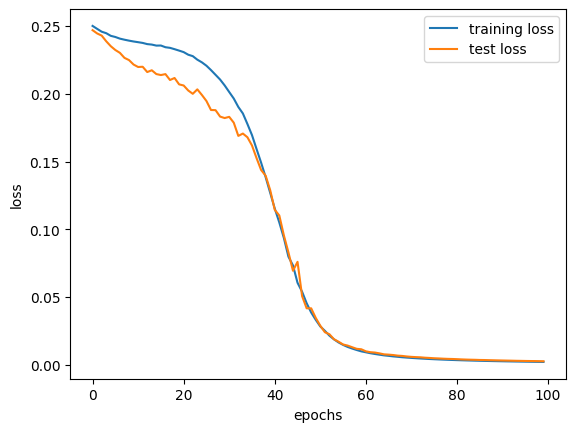

In [111]:
import matplotlib.pyplot as plt

plt.plot(range(NUM_EPOCHS), res['train_loss'], label='training loss')
plt.plot(range(NUM_EPOCHS), res['test_loss'], label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

The loss is quite low for both test and training, so we expect to be able to predict the sums of 5-dimensional binary numbers (as long as their sum does not exceed 5) quite well.

In [112]:
import numpy as np

def predict(num1: int, num2: int, BIN_DIM=5):
  sum_val = num1 + num2
  num1 = int2bin(num1, BIN_DIM)
  num2 = int2bin(num2, BIN_DIM)
  sum_val = int2bin(sum_val, BIN_DIM)

  print(f"Adding {num1} and {num2}. Expecting {sum_val}.")

  X = torch.Tensor([num1[::-1], num2[::-1]]).unsqueeze(0).to(device)
  model.eval()
  with torch.inference_mode():
    pred = model(X).squeeze()
    print(f"Our model predicts: {pred.tolist()[::-1]}")
    print(f"Which rounds to {[int(np.round(el)) for el in pred.tolist()[::-1]]}")


Let's make some predictions!

In [113]:
predict(15,11)

Adding [0, 1, 1, 1, 1] and [0, 1, 0, 1, 1]. Expecting [1, 1, 0, 1, 0].
Our model predicts: [0.9725123047828674, 0.8986209630966187, 0.10013053566217422, 0.9609777331352234, 0.026279088109731674]
Which rounds to [1, 1, 0, 1, 0]


In [114]:
predict(1,8)

Adding [0, 0, 0, 0, 1] and [0, 1, 0, 0, 0]. Expecting [0, 1, 0, 0, 1].
Our model predicts: [0.00843849778175354, 0.9635151028633118, 0.0217409897595644, 0.030220847576856613, 0.9391874074935913]
Which rounds to [0, 1, 0, 0, 1]
